# Image to Parquet
Convert images to binary and save them into a parquet file.

In [ ]:
%load_ext autoreload
%autoreload 2

## Join image DataFrame with Metadata files

In [ ]:
import os
from pathlib import Path
from pyspark.sql.functions import lit, regexp_replace, split, element_at
from pyspark.sql import Row
from pyspark.sql import functions as F
from snakeclef.utils import get_spark

spark = get_spark()
display(spark)

In [ ]:
# Base directory using pathlib
curr_dir = Path(os.getcwd())
base_dir = curr_dir.parents[1] / "data" / "SnakeCLEF2023-small_size"

# Load all files from the base directory as binary data
# Convert Path object to string when passing to PySpark
image_df = (
    spark.read.format("binaryFile")
    .option("pathGlobFilter", "*.jpg")
    .option("recursiveFileLookup", "true")
    .load(base_dir.as_posix())
)

# Construct the string to be replaced - adjust this based on your actual base path
to_remove = "file:" + str(base_dir.parents[0])

# Remove "file:{base_dir.parents[0]" from path column
image_df = image_df.withColumn("path", regexp_replace("path", to_remove, ""))

# Split the path into an array of elements
split_path = split(image_df["path"], "/")

# Extract metadata from the file path
image_final_df = (
    image_df.withColumn("folder_name", element_at(split_path, -4))
    .withColumn("year", element_at(split_path, -3))
    .withColumn("binomial_name", element_at(split_path, -2))
    .withColumn("file_name", element_at(split_path, -1))
)

# Select and rename columns to fit the target schema, including renaming 'content' to 'image_binary_data'
image_final_df = image_final_df.select(
    "path",
    "folder_name",
    "year",
    "binomial_name",
    "file_name",
    image_final_df["content"].alias("data"),
)

# Create a new column "image_path" by removing "/SnakeCLEF2023-small_size/" from "path"
image_final_df = image_final_df.withColumn(
    "image_path", regexp_replace("path", f"^/{base_dir.parts[-1]}/", "")
)

# Print Schema
image_final_df.printSchema()

In [ ]:
image_final_df.show(n=3, truncate=100)

### join image_df with metadata from GCS

In [ ]:
# Get list of stored filed in cloud bucket
! gcloud storage ls gs://dsgt-clef-snakeclef-2024/raw

In [ ]:
raw_root = "gs://dsgt-clef-snakeclef-2024/raw/"
meta_dataset_name = "SnakeCLEF2023-TrainMetadata-iNat"

# Read the iNaturalist metadata CSV file
meta_df = spark.read.csv(
    f"{raw_root}/{meta_dataset_name}.csv",
    header=True,
    inferSchema=True,
)

# Cache the DataFrame to optimize subsequent operations
meta_df.cache()

# Drop duplicate entries based on 'image_path' before the join
meta_df = meta_df.dropDuplicates(["image_path"])

# Assuming you want to process image paths in a similar manner
train_root = Path("/mnt/data/SnakeCLEF2023-small_size")
paths = sorted([p.relative_to(train_root) for p in train_root.glob("**/*.jpg")])

# Create a DataFrame from the paths
path_df = spark.createDataFrame([Row(path=p.as_posix()) for p in paths])

# Let's join the metadata DataFrame with the paths DataFrame
joined_meta_df = meta_df.join(path_df, meta_df.image_path == path_df.path, "inner")

# Dropping columns to avoid confusion
joined_meta_df = joined_meta_df.drop("path", "binomial_name")

joined_meta_df.show(n=3, truncate=100)

In [ ]:
meta_df.count(), path_df.count(), joined_meta_df.count()

In [ ]:
# Perform an inner join on the 'image_path' column
final_df = image_final_df.join(joined_meta_df, "image_path", "inner")

# Show the result to verify the join
final_df.show(n=3, truncate=100)

In [ ]:
final_df.count()

In [ ]:
final_df.printSchema()

## Load DataFrame from GCS

In [1]:
from snakeclef.utils import get_spark

spark = get_spark()
display(spark)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/02/05 16:26:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# Get list of stored filed in cloud bucket
! gcloud storage ls gs://dsgt-clef-snakeclef-2024/data/parquet_files/

gs://dsgt-clef-snakeclef-2024/data/parquet_files/

gs://dsgt-clef-snakeclef-2024/data/parquet_files/:
gs://dsgt-clef-snakeclef-2024/data/parquet_files/
gs://dsgt-clef-snakeclef-2024/data/parquet_files/acm_image_data_test_repartition/
gs://dsgt-clef-snakeclef-2024/data/parquet_files/image_data/


In [3]:
from pyspark.sql.types import (
    StructType,
    StructField,
    StringType,
    BinaryType,
    IntegerType,
    BooleanType,
)

# Define the schema based on the provided structure
schema = StructType(
    [
        StructField("image_path", StringType(), True),
        StructField("path", StringType(), True),
        StructField("folder_name", StringType(), False),
        StructField("year", StringType(), True),
        StructField("binomial_name", StringType(), True),
        StructField("file_name", StringType(), True),
        StructField("data", BinaryType(), True),
        StructField("observation_id", IntegerType(), True),
        StructField("endemic", BooleanType(), True),
        StructField("code", StringType(), True),
        StructField("class_id", IntegerType(), True),
        StructField("subset", StringType(), True),
    ]
)

# Define the GCS path to the Parquet file
gcs_parquet_path = "gs://dsgt-clef-snakeclef-2024/data/parquet_files/image_data"

# Read the Parquet file into a DataFrame
df = spark.read.schema(schema).parquet(gcs_parquet_path)

# Show the data (for example, first few rows)
df.show(n=3)

+--------------------+--------------------+--------------------+----+--------------------+-------------+--------------------+--------------+-------+----+--------+------+
|          image_path|                path|         folder_name|year|       binomial_name|    file_name|                data|observation_id|endemic|code|class_id|subset|
+--------------------+--------------------+--------------------+----+--------------------+-------------+--------------------+--------------+-------+----+--------+------+
|1993/Phrynonax_po...|/SnakeCLEF2023-sm...|SnakeCLEF2023-sma...|1993| Phrynonax_polylepis|102870166.jpg|[FF D8 FF E0 00 1...|      64030606|  false|  EC|    1287| train|
|1995/Acrantophis_...|/SnakeCLEF2023-sm...|SnakeCLEF2023-sma...|1995|Acrantophis_dumerili| 99694826.jpg|[FF D8 FF E0 00 1...|      62240606|   true|  MG|      11| train|
|1996/Ficimia_stre...|/SnakeCLEF2023-sm...|SnakeCLEF2023-sma...|1996|   Ficimia_streckeri| 29265846.jpg|[FF D8 FF E0 00 1...|       2442697|  false|  

In [4]:
import io
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


def display_images_from_binary(image_data_list, binomial_names, grid_size=(3, 3)):
    """
    Display images in a grid with binomial names as labels.

    :param image_data_list: List of binary image data.
    :param binomial_names: List of binomial names corresponding to each image.
    :param grid_size: Tuple (rows, cols) representing the grid size.
    """
    # Unpack the number of rows and columns for the grid
    rows, cols = grid_size

    # Create a matplotlib subplot with the specified grid size
    fig, axes = plt.subplots(rows, cols, figsize=(12, 12), dpi=80)

    # Flatten the axes array for easy iteration if it's 2D
    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

    for ax, binary_data, name in zip(axes, image_data_list, binomial_names):
        # Convert binary data to an image and display it
        image = Image.open(io.BytesIO(binary_data))
        ax.imshow(image)
        name = name.replace("_", " ")
        ax.set_xlabel(name)  # Set the binomial name as xlabel
        ax.xaxis.label.set_size(14)  # Set the font size for the xlabel
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    plt.show()

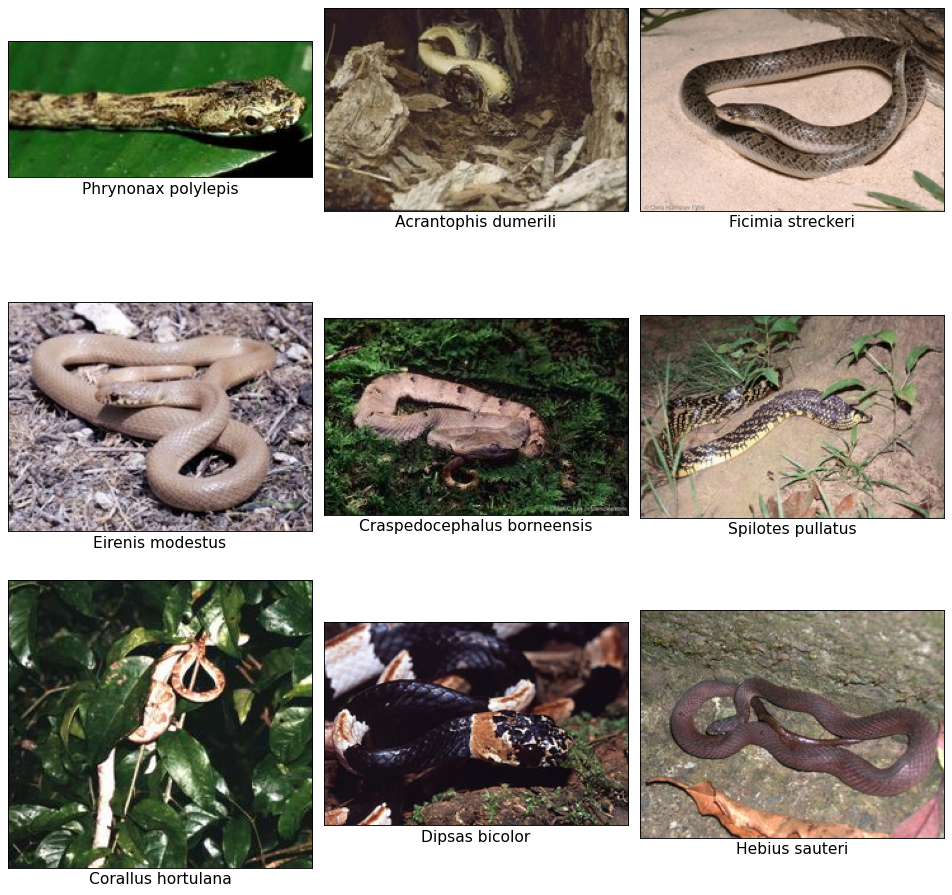

In [5]:
# Collect binary image data from DataFrame
rows, cols = 3, 3
image_data_list = [row["data"] for row in df.limit(rows * cols).collect()]
binomial_names = [row["binomial_name"] for row in df.limit(rows * cols).collect()]

# Display the images in a grid with binomial names
display_images_from_binary(image_data_list, binomial_names, grid_size=(3, 3))